# InterviewMate - Analysis with TF-IDF vs Word2vec vs Sentence Transformers

Understanding string data by cleaning and implementing with TF-IDF, Word2Vec, Sentence Embeddings. 

Word2Vec showed higher cosine numbers, but semantic evaluation + label-based accuracy proved Sentence Transformers produced more meaningful matches. Therefore I chose Sentence Transformers for the real system

In [28]:
# %pip install wordcloud matplotlib  
# %pip install nltk gensim
# %pip install sentence-transformers   

In [43]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity  
from gensim.models import Word2Vec  
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer   
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('../data/Resume/Resume.csv')
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


| Column        | Meaning               | How you should use it                       |
| ------------- | --------------------- | ------------------------------------------- |
| `ID`          | Resume identifier     | For reference / joining / saving            |
| `Resume_str`  | Plain text resume     | **Main text for NLP + ML**                  |
| `Resume_html` | Resume with structure | Optional — can extract sections             |
| `Category`    | Job/industry label    | Useful for supervised learning / evaluation |


In [5]:
df.isnull().sum()

ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64

In [11]:
stop_words = set(stopwords.words('english'))    

def preprocess_text(text):  
    text = text.lower()  
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  
    text = re.sub(r'\@w+|\#','', text)  
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    text_tokens = text.split()  
    filtered_text = ' '.join([word for word in text_tokens if word not in stop_words])  
    return filtered_text
df['Cleaned_Resume'] = df['Resume_str'].apply(preprocess_text)

In [12]:
df['Category'].value_counts()

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

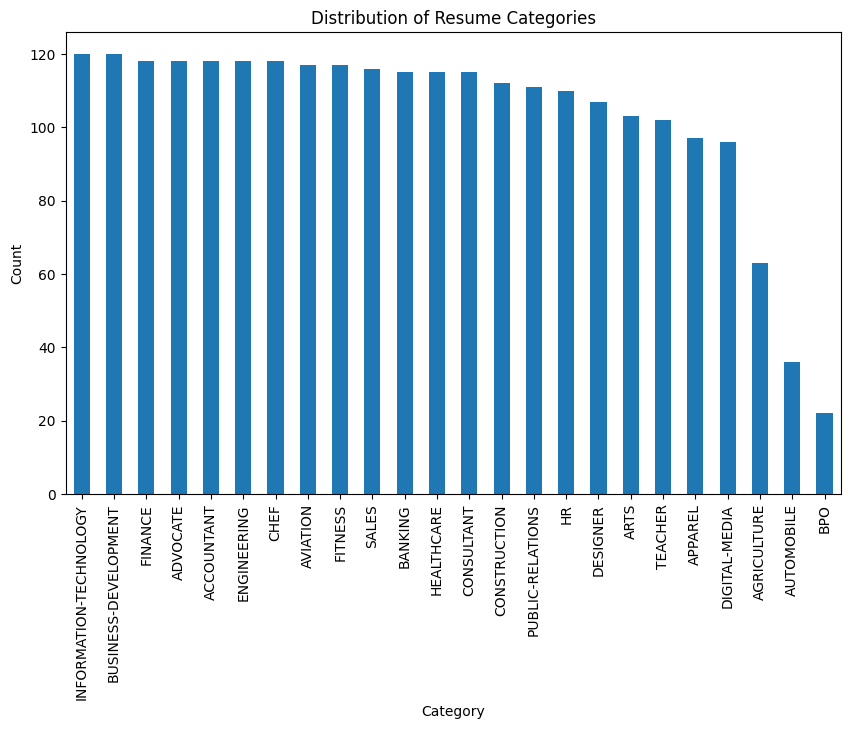

In [13]:
plt.figure(figsize=(10,6))
df['Category'].value_counts().plot(kind='bar')
plt.title('Distribution of Resume Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


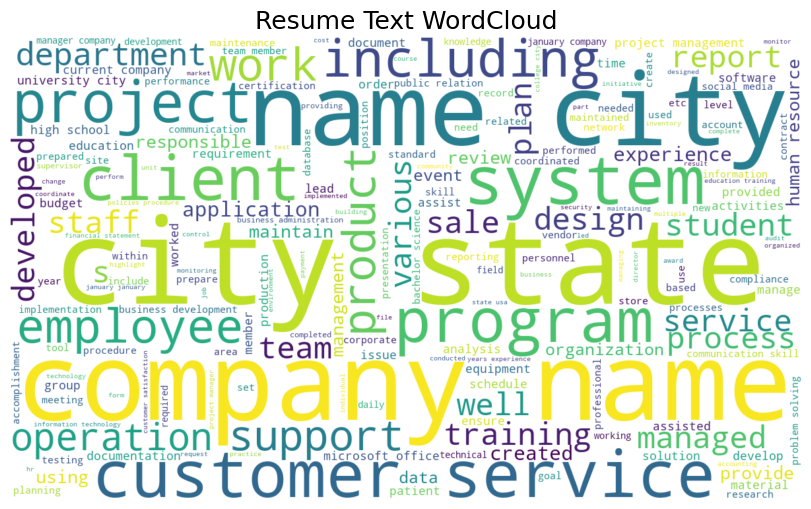

In [14]:
text = " ".join(df['Resume_str'].astype(str).tolist())
text = re.sub(r'[^A-Za-z\s]', ' ', text)
text = text.lower()

stopwords = set(STOPWORDS)
text = " ".join([w for w in text.split() if w not in stopwords])

wordcloud = WordCloud(width=1200, height=700,
                      background_color="white").generate(text)

img = wordcloud.to_image()

plt.figure(figsize=(12,6))
plt.imshow(img, interpolation="bilinear")
plt.axis("off")
plt.title("Resume Text WordCloud", fontsize=18)
plt.show()


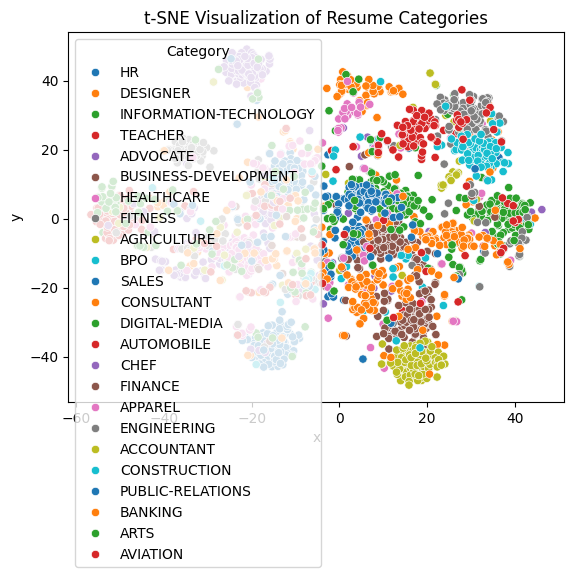

In [44]:
# Use precomputed sentence embeddings if available to avoid re-encoding and NameError
# Fallback to using sent_transformer if embeddings are not present
if 'embeddings' in globals():
	data_embeddings = embeddings
elif 'sent_transformer' in globals():
	data_embeddings = [sent_transformer.encode(x) for x in df['Cleaned_Resume'].tolist()]
else:
	# As a last resort, instantiate a local SentenceTransformer (downloads model if needed)
	from sentence_transformers import SentenceTransformer
	sent_transformer_local = SentenceTransformer('all-MiniLM-L6-v2')
	data_embeddings = sent_transformer_local.encode(df['Cleaned_Resume'].tolist())

m = TSNE(learning_rate=100, random_state=42, n_components=2, init='pca')
tsne_features = m.fit_transform(data_embeddings)
df['y'] = tsne_features[:, 1]
df['x'] = tsne_features[:, 0]

sns.scatterplot(data=df, x='x', y='y', hue='Category', palette='tab10')
plt.title('t-SNE Visualization of Resume Categories')
plt.show()


## TF-IDF Similaries 


In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf.fit_transform(df['Cleaned_Resume'])


In [24]:
test_resume = " Experienced software developer with expertise in Python, machine learning, and data analysis. Skilled in building web applications and working with large datasets. "
test_vector = tfidf.transform([preprocess_text(test_resume)])   
cosine_similarities = cosine_similarity(test_vector, tfidf_matrix).flatten()

similar_indices = cosine_similarities.argsort()[-5:][::-1]

print("Top 5 similar resumes:")
for index in similar_indices:
    print(f"Resume Index: {index}, Similarity Score: {cosine_similarities[index]:.4f}")
    print(df.iloc[index]['Resume_str'][:500])  
    print("-----")  



Top 5 similar resumes:
Resume Index: 1762, Similarity Score: 0.2138
         ENGINEERING AND QUALITY TECHNICIAN       Career Overview    A highly experienced skilled graduate with Analytics degree with a very good experience in SAS, Web scraping, SQL, Predictive modelling and data visualization. Excellent ability in identifying data requirements for analysis, data cleaning, munging and model building; Ensures the organization uses it effectively to reach profit and growth objectives. Comfortable with data handling, modeling, and coding, and have an appreciation 
-----
Resume Index: 1218, Similarity Score: 0.1973
       Pavithra  Shetty           Summary     Customer-oriented Principal Consultant knowledgeable about developing and implementing successful business solutions that drive productivity and growth. Offering expertise in SQL, Data Visualization, Scripting language and more than 6 years of experience in the software industry.       Experience      Principal Consultant   Company 

TF-IDF similarities drop very low because sparse vectors rarely align → values like 0.2 are normal:

ENGINEERING AND QUALITY TECHNICIAN … data visualization, SQL, predictive modeling

Not terrible — same engineering domain, meaningful match.

## Word2Vec

In [23]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_sentence_vector(text, model):
    words = [w for w in text.split() if w in model]
    if not words:
        return np.zeros(model.vector_size)
    vectors = np.array([model[w] for w in words])
    return np.mean(vectors, axis=0)   # or np.sum(vectors, axis=0)

# Test resume vector
test_vector_w2v = get_sentence_vector(preprocess_text(test_resume), word_vectors)

cosine_similarities_w2v = []
for resume in df['Cleaned_Resume']:
    resume_vector = get_sentence_vector(resume, word_vectors)

    sim = cosine_similarity(
        test_vector_w2v.reshape(1, -1),
        resume_vector.reshape(1, -1)
    )[0][0]

    cosine_similarities_w2v.append(sim)

similar_indices_w2v = pd.Series(cosine_similarities_w2v).argsort()[-5:][::-1]

print("Top 5 similar resumes using Word2Vec:")
for index in similar_indices_w2v:
    print(f"Resume Index: {index}, Similarity Score: {cosine_similarities_w2v[index]:.4f}")
    print(df.iloc[index]['Resume_str'][:500])
    print("-----")


Top 5 similar resumes using Word2Vec:
Resume Index: 1111, Similarity Score: 0.8974
         IT CONSULTANT           Summary      Over Seven years of Software Application Development, Application Support, Testing and Implementation experience with Web based and N-tier Architectures involving all stages of Software Development Life Cycle (SDLC).   Experience in developing Web applications in . SDLC) including requirements, logical and physical architecture modeling, design, development, implementation, and support.   Ability to work in a fast paced, collaborative environment and
-----
Resume Index: 2184, Similarity Score: 0.8968
         SOFTWARE ENGINEER             Qualifications        C# 3.0, PL/SQL, JavaScript, HTML 4, CSS 2  Framework: .NET 3.5  Database: SQL Server 2008, Oracle 9i  Operating systems: Windows 98/XP, Windows server 2000/2005, UNIX  Tools/Services: TOAD, HP Service Manager, WinSCP, PuTTY, PM Smart, vi text editor, Visual  SourceSafe and BusinessObjects XI 3.1 Univers

Word2Vec cosine values commonly range ~0.8 – 0.95 for similar technical documents

But read the text:

- generic IT consultant resumes
- repeated buzzwords
- long similar corporate template sentences

Word2Vec often:

- Overweights common tech phrases

- Averages word vectors → documents with many technical buzzwords look similar

- Can be fooled by resume length + standard corporate wording

So Word2Vec can give high score but shallow reasoning.

## Embedding - Sentence transformers

In [30]:
sent_transformer = SentenceTransformer('all-MiniLM-L6-v2')  
embeddings = sent_transformer.encode(df['Cleaned_Resume'].tolist()) 

In [31]:
test_embedding = sent_transformer.encode([preprocess_text(test_resume)])[0] 
cosine_similarities_st = cosine_similarity(
    test_embedding.reshape(1, -1),
    embeddings
).flatten()
similar_indices_st = cosine_similarities_st.argsort()[-5:][::-1]
print("Top 5 similar resumes using Sentence Transformers:")
for index in similar_indices_st:
    print(f"Resume Index: {index}, Similarity Score: {cosine_similarities_st[index]:.4f}")
    print(df.iloc[index]['Resume_str'][:500])  
    print("-----")
    

Top 5 similar resumes using Sentence Transformers:
Resume Index: 1762, Similarity Score: 0.5850
         ENGINEERING AND QUALITY TECHNICIAN       Career Overview    A highly experienced skilled graduate with Analytics degree with a very good experience in SAS, Web scraping, SQL, Predictive modelling and data visualization. Excellent ability in identifying data requirements for analysis, data cleaning, munging and model building; Ensures the organization uses it effectively to reach profit and growth objectives. Comfortable with data handling, modeling, and coding, and have an appreciation 
-----
Resume Index: 926, Similarity Score: 0.5280
           SOFTWARE DEVELOPER         Professional Summary    Enthusiastic computer engineer eager to contribute to team success through hard work, attention to detail and excellent organizational skills. Technical professional with complete understanding of entire software development life cycle. Respectful self-motivator gifted at finding reliable s

Sentence Transformers:

- Understands sentence meaning

- Less fooled by repeated buzzwords

- Handles paraphrasing

Even though number looks lower, it is more semantically meaningful.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['Category'], test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000) 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


                        precision    recall  f1-score   support

            ACCOUNTANT       0.83      0.86      0.85        29
              ADVOCATE       0.53      0.60      0.56        30
           AGRICULTURE       1.00      0.12      0.22         8
               APPAREL       0.53      0.45      0.49        20
                  ARTS       0.11      0.11      0.11        18
            AUTOMOBILE       1.00      0.17      0.29         6
              AVIATION       0.78      0.86      0.82        21
               BANKING       0.75      0.65      0.70        23
                   BPO       0.00      0.00      0.00         2
  BUSINESS-DEVELOPMENT       0.89      0.59      0.71        27
                  CHEF       0.85      0.71      0.77        24
          CONSTRUCTION       0.90      0.76      0.83        34
            CONSULTANT       0.46      0.30      0.36        20
              DESIGNER       0.71      0.79      0.75        19
         DIGITAL-MEDIA       0.94      

C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas

In [47]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, df['Category'], test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000) 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


                        precision    recall  f1-score   support

            ACCOUNTANT       0.93      0.97      0.95        29
              ADVOCATE       0.63      0.57      0.60        30
           AGRICULTURE       0.33      0.12      0.18         8
               APPAREL       0.47      0.35      0.40        20
                  ARTS       0.17      0.11      0.13        18
            AUTOMOBILE       0.00      0.00      0.00         6
              AVIATION       0.70      0.76      0.73        21
               BANKING       0.80      0.70      0.74        23
                   BPO       0.00      0.00      0.00         2
  BUSINESS-DEVELOPMENT       0.96      0.81      0.88        27
                  CHEF       0.91      0.83      0.87        24
          CONSTRUCTION       0.87      0.76      0.81        34
            CONSULTANT       0.89      0.80      0.84        20
              DESIGNER       0.77      0.89      0.83        19
         DIGITAL-MEDIA       0.74      

C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas